In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.io import fits
from astropy.table import Table

In [20]:
filename = '/mnt/data-storage/apogee/dr17/allStar-dr17-synspec_rev1.fits'

with fits.open(filename) as hdul:
    table = Table.read(hdul[1])

In [21]:
names = [name for name in table.colnames if len(table[name].shape) <= 1]
df = table[names].to_pandas()
df["GAIAEDR3_PARALLAX_OVER_ERROR"] = df['GAIAEDR3_PARALLAX'] / df['GAIAEDR3_PARALLAX_ERROR']
df.head()

,FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,...,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,GAIAEDR3_PARALLAX_OVER_ERROR
0,apStar-dr17-VESTA.fits,VESTA,apo1m.calibration.VESTA,apogee.apo1m.stars.calibration.VESTA,apogee.apo1m.synspec_fix.calibration.VESTA,apo1m,1,calibration,,NaN,...,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2,NaN
1,apStar-dr17-2M00000002+7417074.fits,2M00000002+7417074,apo25m.120+12.2M00000002+7417074,apogee.apo25m.stars.120+12.2M00000002+7417074,apogee.apo25m.synspec_fix.120+12.2M00000002+74...,apo25m,5046,120+12,none,0.000103,...,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2,14.656825
2,apStar-dr17-2M00000019-1924498.fits,2M00000019-1924498,apo25m.060-75.2M00000019-1924498,apogee.apo25m.stars.060-75.2M00000019-1924498,apogee.apo25m.synspec_fix.060-75.2M00000019-19...,apo25m,5071,060-75,none,0.000832,...,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2,0.260545
3,apStar-dr17-2M00000032+5737103.fits,2M00000032+5737103,apo25m.116-04.2M00000032+5737103,apogee.apo25m.stars.116-04.2M00000032+5737103,apogee.apo25m.synspec_fix.116-04.2M00000032+57...,apo25m,4424,116-04,none,0.001335,...,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2,136.365234
4,apStar-dr17-2M00000032+5737103.fits,2M00000032+5737103,apo25m.N7789.2M00000032+5737103,apogee.apo25m.stars.N7789.2M00000032+5737103,apogee.apo25m.synspec_fix.N7789.2M00000032+573...,apo25m,4264,N7789,none,0.001335,...,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2,136.365234


In [22]:
def any_bits_in_bitmask(bitmask, bits=None):
    if bits is None:
        bits = range(0, np.iinfo(bitmask).bits)
    return any((bitmask & 1 << bit) > 0 for bit in bits)

In [23]:
# M_H_WARN, ALPHA_M_WARN, STAR_WARN, M_H_BAD, ALPHA_M_BAD, STAR_BAD, or MULTIPLE_SUSPECT
# bits = [3, 4, 7, 19, 20, 23, 41]
# M_H_BAD, ALPHA_M_BAD, STAR_BAD, or MULTIPLE_SUSPECT
bits = [19, 20, 23, 41]
flag = df['ASPCAPFLAG'].apply(any_bits_in_bitmask, args=(bits,))
print(flag.sum(), 'stars flagged')

48264 stars flagged


In [24]:
mask = (
    (df['GAIAEDR3_PARALLAX'] > 1) & (df['GAIAEDR3_PARALLAX_OVER_ERROR'] > 5)
    & (df["M_H"] > -0.9)
    & (df['ALPHA_M'] > -0.3) & (df['ALPHA_M'] < 0.3)
    & (df['LOGG'] > 2.5)
    & ~(
        ((df['TEFF'] - df['TEFF_ERR']) < 4500.)
#         & ((df['LOGG'] + df['LOGG_ERR']) > 4.2)
    )
    & ~flag
)
print(mask.sum(), 'stars selected')

215626 stars selected


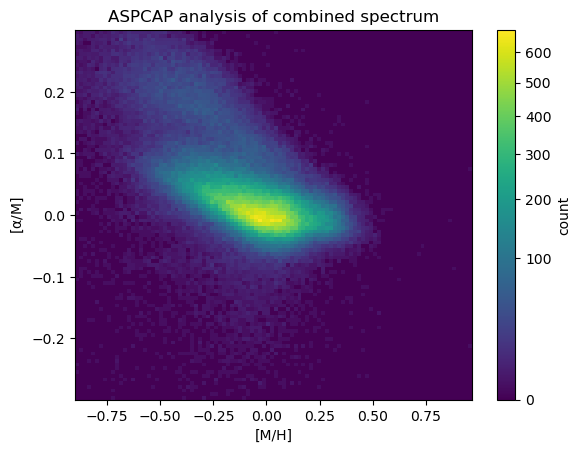

In [25]:
fig, ax = plt.subplots()

*_, im = ax.hist2d(df.loc[mask, 'M_H'], df.loc[mask, 'ALPHA_M'], bins=100, norm=mcolors.PowerNorm(1/2))

ax.set_xlabel('[M/H]')
ax.set_ylabel(r'$[\mathrm{\alpha/M}]$')
ax.set_title('ASPCAP analysis of combined spectrum')
fig.colorbar(im, label='count');

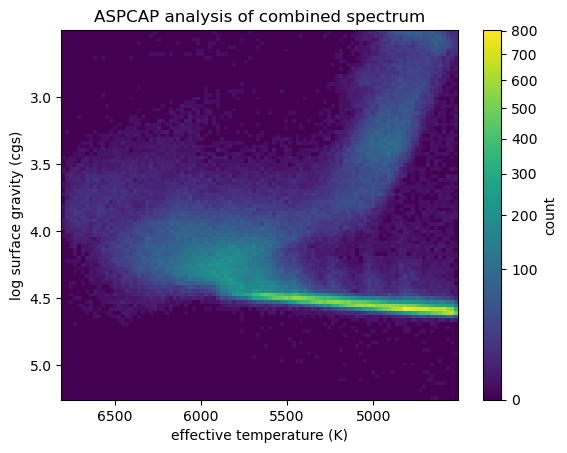

In [26]:
fig, ax = plt.subplots()

*_, im = ax.hist2d(df.loc[mask, 'TEFF'], df.loc[mask, 'LOGG'], bins=100, norm=mcolors.PowerNorm(1/2))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('effective temperature (K)')
ax.set_ylabel('log surface gravity (cgs)')
ax.set_title('ASPCAP analysis of combined spectrum')
fig.colorbar(im, label="count");

In [27]:
num_samples = 10000
idx = df.loc[mask].sample(num_samples).index

(4.8, 2.2)

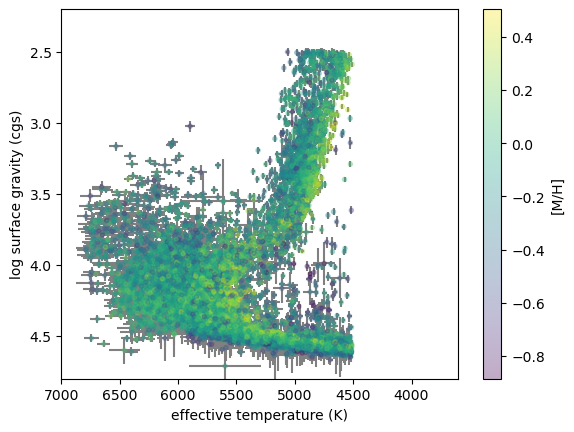

In [28]:
fig, ax = plt.subplots()

ax.errorbar(
    df.loc[mask, 'TEFF'].loc[idx], 
    df.loc[mask, 'LOGG'].loc[idx], 
    xerr=df.loc[mask, 'TEFF_ERR'].loc[idx],
    yerr=df.loc[mask, 'LOGG_ERR'].loc[idx],
    ls='none',
    zorder=0,
    c='gray',
)
s = ax.scatter(df.loc[mask, 'TEFF'].loc[idx], df.loc[mask, 'LOGG'].loc[idx], 
               c=df.loc[mask, 'M_H'].loc[idx], marker='.', alpha=0.33)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('effective temperature (K)')
ax.set_ylabel('log surface gravity (cgs)')
fig.colorbar(s, label='[M/H]');

ax.set_xlim(7000, 3600)
ax.set_ylim(4.8, 2.2)

In [29]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
from isochrones.interp import DFInterpolator

In [30]:
bc_grid = MISTBolometricCorrectionGrid(['J', 'H', 'K', 'G', 'BP', 'RP', 'g', 'r', 'i'])
bc_grid.df.head()

g         r         i         J         H  \
Teff   logg [Fe/H] Av                                                       
2500.0 -4.0 -4.0   0.00 -6.534742 -3.332877 -1.617626  1.845781  2.927064   
                   0.05 -6.590469 -3.375570 -1.650338  1.831466  2.917990   
                   0.10 -6.646182 -3.418258 -1.683043  1.817153  2.908916   
                   0.15 -6.701881 -3.460939 -1.715740  1.802841  2.899842   
                   0.20 -6.757566 -3.503615 -1.748429  1.788530  2.890769   

                                K         G        BP        RP  
Teff   logg [Fe/H] Av                                            
2500.0 -4.0 -4.0   0.00  3.436304 -2.181987 -4.652549 -0.881256  
                   0.05  3.430463 -2.211638 -4.697705 -0.909058  
                   0.10  3.424623 -2.241241 -4.742843 -0.936830  
                   0.15  3.418782 -2.270798 -4.787964 -0.964572  
                   0.20  3.412942 -2.300307 -4.833067 -0.992286

In [31]:
bc = bc_grid.df.reset_index()
mask = (bc['Teff'] < 2e4) & (bc['logg'] > 2) & (bc['logg'] < 5) & (bc['[Fe/H]'] > -1)
bc = bc.loc[mask].set_index(['Teff', 'logg', '[Fe/H]', 'Av'])
bc.head()

g         r         i         J         H  \
Teff   logg [Fe/H] Av                                                       
2500.0 2.5  -0.75  0.00 -5.637413 -4.568194 -1.400539  2.060398  2.639860   
                   0.05 -5.696952 -4.611316 -1.432710  2.046009  2.630782   
                   0.10 -5.756448 -4.654431 -1.464876  2.031621  2.621704   
                   0.15 -5.815901 -4.697541 -1.497035  2.017235  2.612627   
                   0.20 -5.875311 -4.740644 -1.529188  2.002850  2.603550   

                                K         G        BP        RP  
Teff   logg [Fe/H] Av                                            
2500.0 2.5  -0.75  0.00  3.002975 -1.991365 -5.242927 -0.625698  
                   0.05  2.997152 -2.019406 -5.293596 -0.652348  
                   0.10  2.991329 -2.047406 -5.344184 -0.678977  
                   0.15  2.985506 -2.075366 -5.394691 -0.705585  
                   0.20  2.979684 -2.103285 -5.445118 -0.732172

In [32]:
interp = DFInterpolator(bc)

Could use this in a model which finds empirical mass and radii from photometry